# Measure Resonant Frequency of weighted and unweighted flowers
## Callin Switzer
15 July 2017

Download nidaq driver for ni USB-6229 (save to thumb drive)

Download/update anaconda

download PyDAQmx

download pySerial

# Setup

In [1]:
# setup arduino
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PyDAQmx import * #works -- need to install NiDACmx (takes like a day to download)

In [3]:
import datetime

import flycapture2 as fc2 # works

In [4]:
import serial # works

In [5]:
import cv2
print cv2.__version__


3.2.0


In [6]:
import time

import os
import peakutils 
import msvcrt
import winsound
import shutil
import pandas as pd

In [7]:
 % qtconsole

In [8]:
PORT1 = "COM3"
connected1 = False
ser1 = serial.Serial(PORT1,9600)
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print "connected to arduino on COM3" 

connected to arduino on COM3


In [19]:
# define function for recording and rewarding buzzes
def recRew(ftestMin, ftestMax):
         
    aThr = [0,5]
    
    # loop to look for specific frequencies
    fmin = 5.0
    fmax = 2000.0

    counterAlarm = 50

    peakFrq = np.array(0)
    pwr = np.array(0)
    pwrCutoff = 0.004 # lower amplitude cutoff
    sleepTime = 0 # seconds

    # make a continuously-sampling loop that will end if it gets a frequency of 280 Hz
    # 100000 samples is one second
    # Note: to get higher resolution for peak freq, I'd need a larger window
    N_samples = 40000 # log for 0.2 seconds
    log_rate = 200000.0

    ctr = 0
    ctr2 = 0
    
    # start buzz timer
    buzzTime = time.time()
    
    # open text file
    with open(str(outDir)+ '_ampFreq.txt', 'a') as text_file:  

        # clear characters waiting to be read
        while msvcrt.kbhit():
            msvcrt.getch()
            print 'clearing characters ...'

        while ctr <= (2*counterAlarm - 1): # only give a max of 100 buzzes
                
            taskHandle = TaskHandle()
            read = int32()
            data = np.zeros((N_samples,), dtype=np.float64)

            DAQmxCreateTask("", byref(taskHandle))
            # I have an piezoelectric accelerometer plugged into channel ai1 with range +/-10V
            DAQmxCreateAIVoltageChan(taskHandle, "Dev1/ai0", 
                                     "Accelerometer", DAQmx_Val_Diff, 
                                     -10.0, 10.0, DAQmx_Val_Volts, None)
            DAQmxCfgSampClkTiming(taskHandle, "", log_rate, 
                                  DAQmx_Val_Rising, 
                                  DAQmx_Val_FiniteSamps, N_samples)

            DAQmxStartTask(taskHandle)
            DAQmxReadAnalogF64(taskHandle, N_samples, 10.0, 
                               DAQmx_Val_GroupByChannel, data, 
                               N_samples, byref(read), None)

            if taskHandle:
                DAQmxStopTask(taskHandle);
                DAQmxClearTask(taskHandle);

            # 20fft
            n =len(data) # length of the signal
            k = np.arange(n, step = 1)
            T = n/log_rate
            frq = k/T # two sides frequency range
            frq = frq[range(n/2)] # one side frequency range

            Y = np.fft.fft(data)/n # fft computing and normalization
            Y = Y[range(n/2)]

            # calculate top frequency
            ind = np.argpartition(abs(Y), -4)[-4:]
            # Find highest point on the spectrum
            peakFrq = frq[ind[::-1]]
            pwr = (abs(Y)[ind[::-1]])
            domPK = [x for (y,x) in sorted(zip(pwr,peakFrq), reverse = True)][0]

            beeFrqPwr = pwr[peakFrq == domPK]
            # print beeFrq in peakFrq, peakFrq[pwr == max(pwr)], beeFrqPwr, beeFrqPwr > 0.3

            # if the bee is vibrating at a high enough power and the dominant peak from the 
            # vibration is in the right range
            if beeFrqPwr > pwrCutoff and domPK > fmin and domPK < fmax:
                buzzTime = time.time()
                
                reward = 'F'

                aamp = np.max(data) - np.min(data)
                # write value to serial port, and get it to start the turn on the motor
                s3 = str(datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S_%f")[:-3]) # time with milliseconds
                print(s3 + " topFreq = " + str(domPK) + " amp = " + str(aamp))

                                
                #print reward number
                print('Counter Number ' + str(ctr))

                ############################### PLOT ##################################
                # create subplot 1
                ax1 = plt.subplot(211)
                ax1.plot(np.array(range(len(data)))/ float(log_rate), data)
                ax1.set_ylabel("Volts")
                ax1.set_xlabel("time (s)")
                if reward == 'T':
                    ax1.set_facecolor('grey')

                # create subplot 2
                ax2 = plt.subplot(212)
                ax2.plot(frq,abs(Y),'r')
                ax2.plot(domPK, beeFrqPwr, 'ro')
                ax2.set_xlim(20, 1000)
                ax2.set_ylabel('power')
                ax2.set_xlabel('frequency')
                plt.tight_layout()
                plt.show()


                #################### SAVE FILE FROM ACCEL ##############################
                np.savetxt((os.getcwd() + '\\' + outDir + '\\' + s3 + '_' + str(ftestMin) + '_' + 
                           str(ftestMax) + '_' + str(aThr[0]) + '_' +  str(aThr[1]) + '.txt'), 
                           (np.array(range(len(data)))/ float(log_rate), data), delimiter = ' ')

                ### write frequency and amplitude to file
                var1 = (str(domPK) + ', ' + 
                           str(round(np.max(data) - np.min(data), 5)) + ', ' + 
                           s3 + ', ' + str(ctr) +', ' + str(reward) + 
                        ',' + str(aThr[0]) + 
                        ',' + str(aThr[1]) + '\n')
                text_file.writelines(var1)

            # break loop if someone presses the 'q' while in terminal
            if msvcrt.kbhit():
                if msvcrt.getch() == 'q':
                    print 'keyboard q pressed, now quitting loop'
                    for i in range(5):
                        winsound.Beep(450,100)
                    break   
                else:
                    written = ser1.write("20")

    # make sound when loop stops
    for i in range(3):
        winsound.Beep(350,500)

new directory created: 2017_07_12__13_52_59
the current python direcory is C:\Users\Combes4\Desktop\ResonantFreq
2017_07_12__13_53_04_050 topFreq = 450.0 amp = 0.712267861029
Counter Number 0


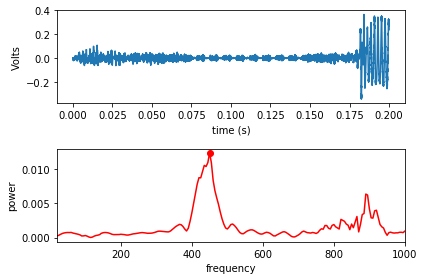

2017_07_12__13_53_04_861 topFreq = 440.0 amp = 0.715512792374
Counter Number 0


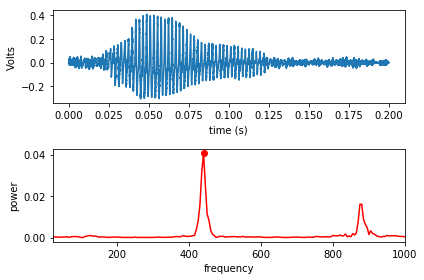

2017_07_12__13_53_05_500 topFreq = 440.0 amp = 0.537364722371
Counter Number 0


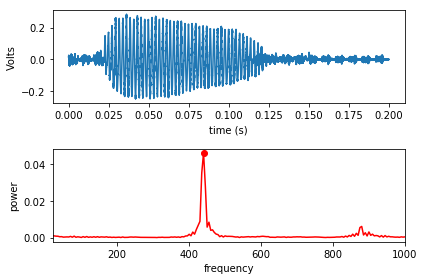

2017_07_12__13_53_06_731 topFreq = 440.0 amp = 0.279390718339
Counter Number 0


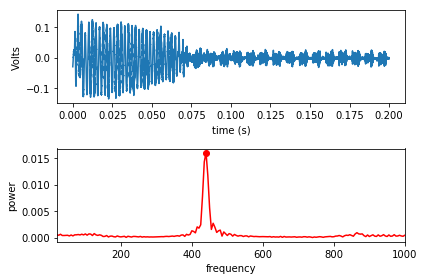

2017_07_12__13_53_08_141 topFreq = 440.0 amp = 0.164519271754
Counter Number 0


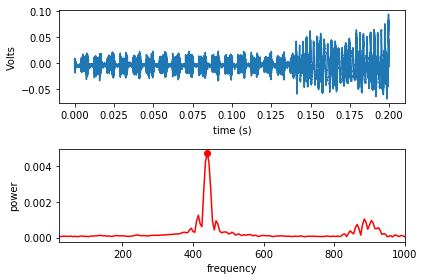

2017_07_12__13_53_08_890 topFreq = 440.0 amp = 0.550669007819
Counter Number 0


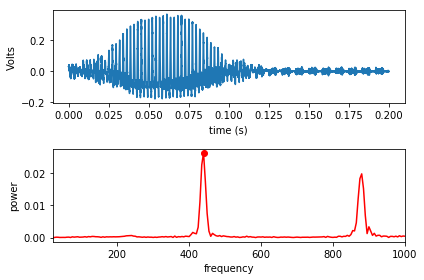

2017_07_12__13_53_10_079 topFreq = 440.0 amp = 2.20949048428
Counter Number 0


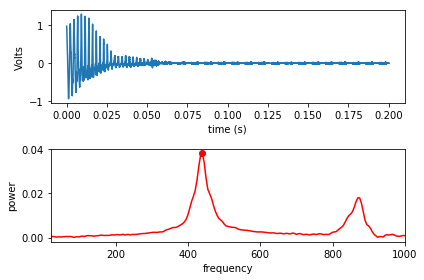

2017_07_12__13_53_10_987 topFreq = 440.0 amp = 0.34948177725
Counter Number 0


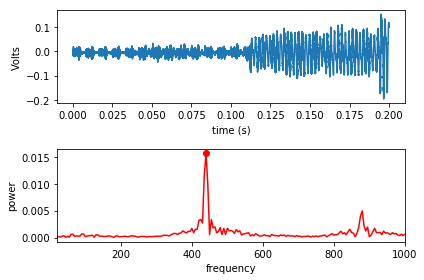

2017_07_12__13_53_11_675 topFreq = 440.0 amp = 0.363110589115
Counter Number 0


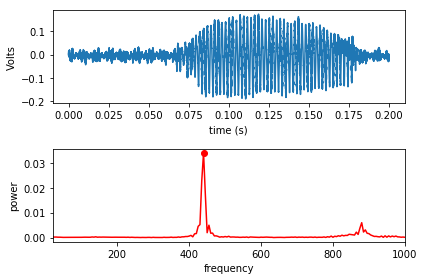

2017_07_12__13_53_14_136 topFreq = 440.0 amp = 0.944606790524
Counter Number 0


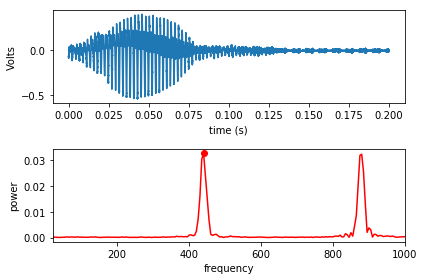

2017_07_12__13_53_14_772 topFreq = 440.0 amp = 0.682089796974
Counter Number 0


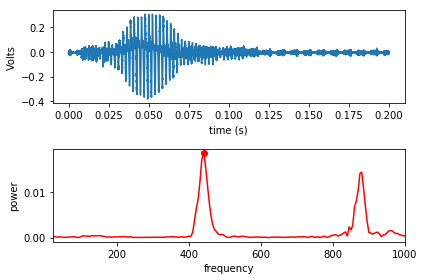

2017_07_12__13_53_16_022 topFreq = 440.0 amp = 0.74893588569
Counter Number 0


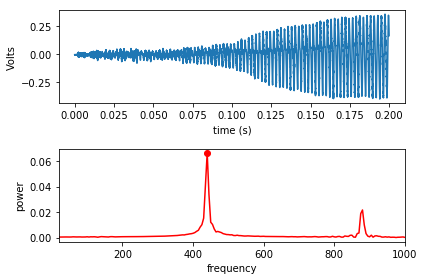

2017_07_12__13_53_16_731 topFreq = 440.0 amp = 0.1872339666
Counter Number 0


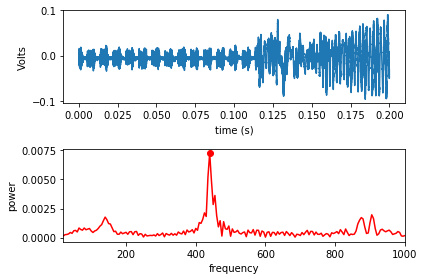

2017_07_12__13_53_17_977 topFreq = 440.0 amp = 0.31054229799
Counter Number 0


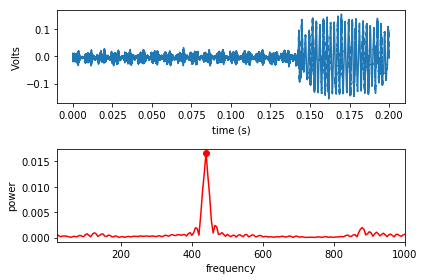

2017_07_12__13_53_18_597 topFreq = 440.0 amp = 0.124281819508
Counter Number 0


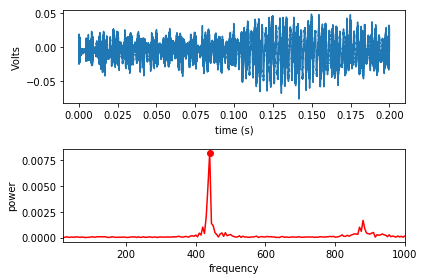

2017_07_12__13_53_20_294 topFreq = 440.0 amp = 0.315734221879
Counter Number 0


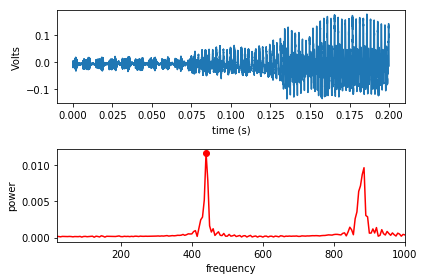

2017_07_12__13_53_21_113 topFreq = 440.0 amp = 0.68533467634
Counter Number 0


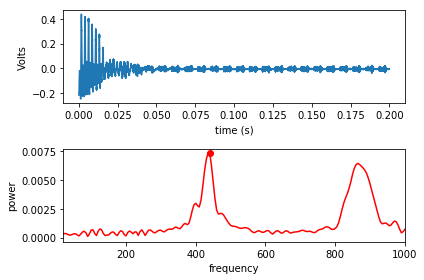

2017_07_12__13_53_22_347 topFreq = 440.0 amp = 0.630170473623
Counter Number 0


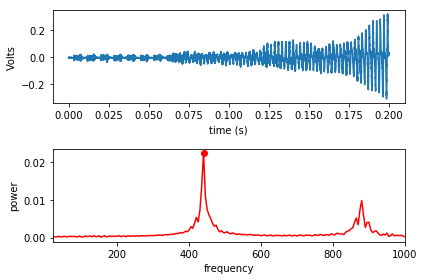

2017_07_12__13_53_23_128 topFreq = 440.0 amp = 0.440340544629
Counter Number 0


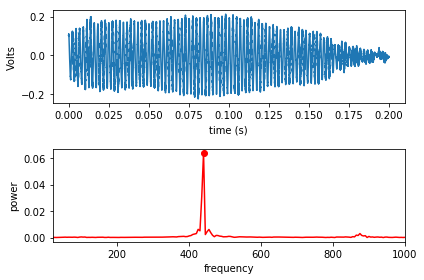

2017_07_12__13_53_23_822 topFreq = 440.0 amp = 0.349806260594
Counter Number 0


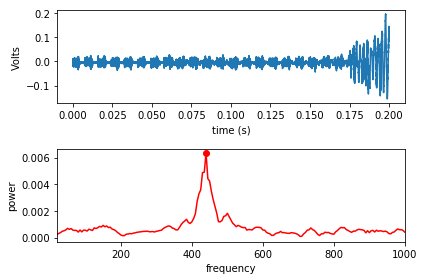

2017_07_12__13_53_24_558 topFreq = 440.0 amp = 0.22974288926
Counter Number 0


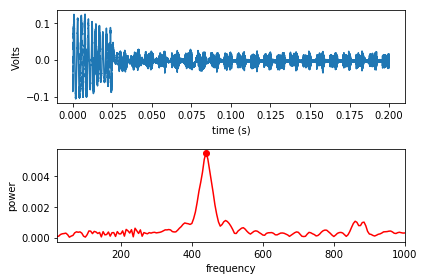

2017_07_12__13_53_25_942 topFreq = 880.0 amp = 1.06467002198
Counter Number 0


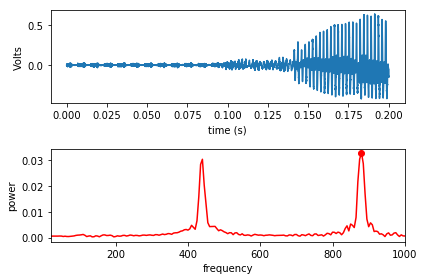

2017_07_12__13_53_26_631 topFreq = 440.0 amp = 0.778464944624
Counter Number 0


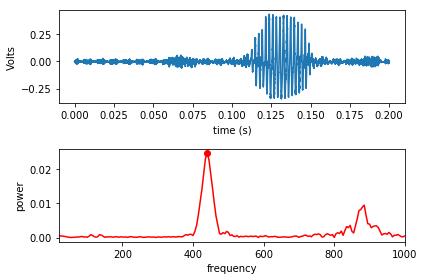

2017_07_12__13_53_27_314 topFreq = 440.0 amp = 0.697016531751
Counter Number 0


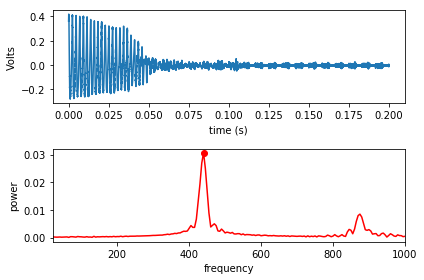

2017_07_12__13_53_28_511 topFreq = 440.0 amp = 0.701559463077
Counter Number 0


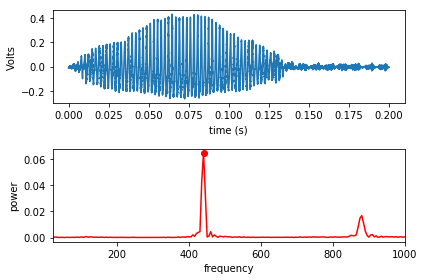

2017_07_12__13_53_30_710 topFreq = 440.0 amp = 0.30956880544
Counter Number 0


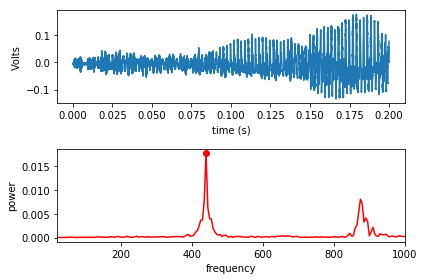

2017_07_12__13_53_31_959 topFreq = 440.0 amp = 1.13995303132
Counter Number 0


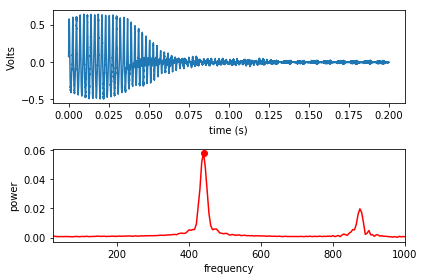

2017_07_12__13_53_33_205 topFreq = 440.0 amp = 0.504915157411
Counter Number 0


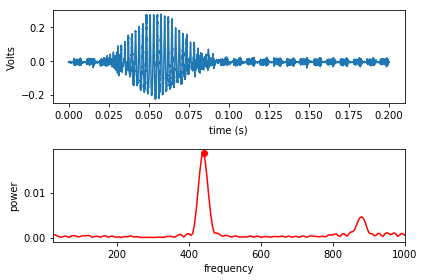

2017_07_12__13_53_34_965 topFreq = 440.0 amp = 0.289125587955
Counter Number 0


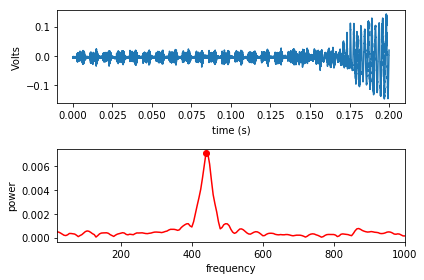

2017_07_12__13_53_36_608 topFreq = 440.0 amp = 0.883601465765
Counter Number 0


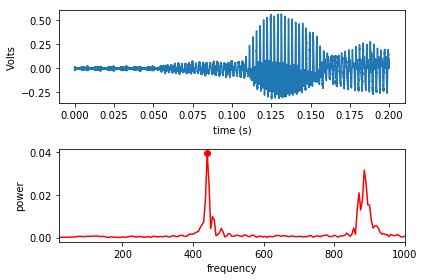

2017_07_12__13_53_37_311 topFreq = 440.0 amp = 0.258298506303
Counter Number 0


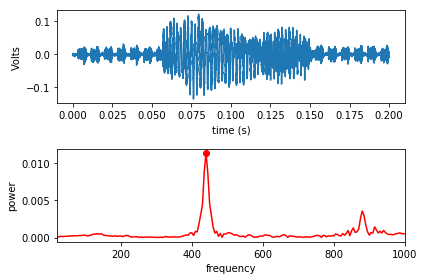

2017_07_12__13_53_38_017 topFreq = 440.0 amp = 2.18093471653
Counter Number 0


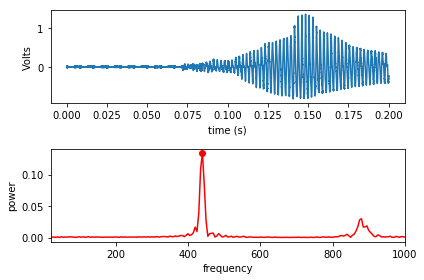

2017_07_12__13_53_38_623 topFreq = 440.0 amp = 0.613296682522
Counter Number 0


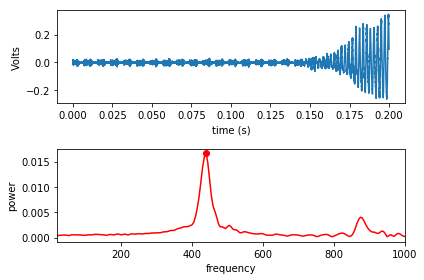

2017_07_12__13_53_39_674 topFreq = 440.0 amp = 0.466949170915
Counter Number 0


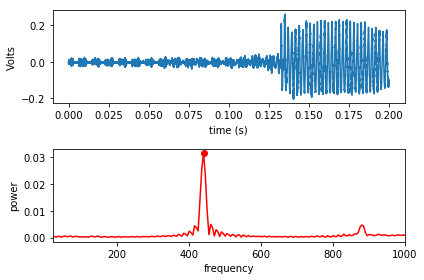

2017_07_12__13_53_41_693 topFreq = 875.0 amp = 0.235908309982
Counter Number 0


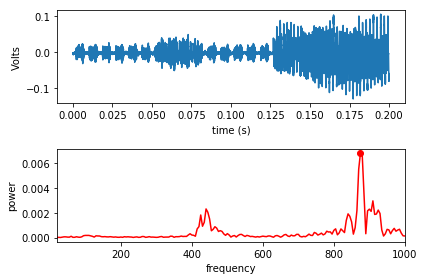

2017_07_12__13_53_42_418 topFreq = 440.0 amp = 1.13897946016
Counter Number 0


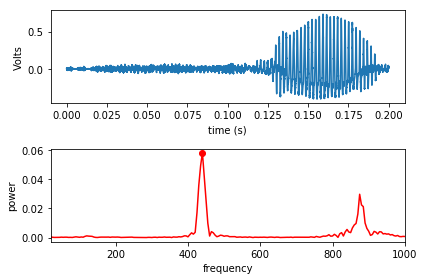

2017_07_12__13_53_43_092 topFreq = 440.0 amp = 1.486189788
Counter Number 0


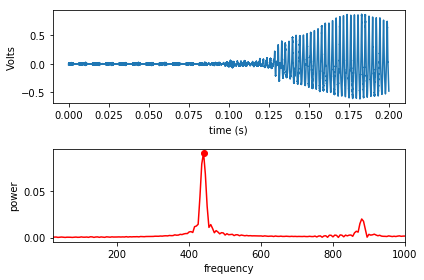

2017_07_12__13_53_43_731 topFreq = 440.0 amp = 0.799881657091
Counter Number 0


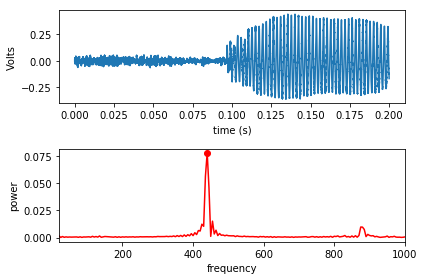

keyboard q pressed, now quitting loop


In [80]:
## reward amplitudes
rewAAmp = "test"

# change python directory to Dropbox
os.chdir('C:/Users/Combes4/Desktop/ResonantFreq/')
os.getcwd()

# make new directory with date, if it doesn't already exist
outDir = (datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S"))
#outDir = 'accelShake_009_05092016'

if not os.path.isdir(os.getcwd() + '\\' + outDir):
    os.mkdir(os.getcwd() + '\\' + outDir)
    
    print 'new directory created: ' + str(outDir)
else: print 'directory exists: '  + str(outDir)

print "the current python direcory is " + str(os.getcwd())
                                                                                                                 
# make new file
open(str(outDir)+ '_ampFreq.txt', 'a').close()


recRew(5, 2000)

463.289473684
440.0
file already exists -- adding to file


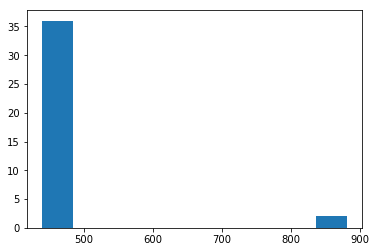

In [81]:
## make new folder and move files into that folder
trt = 'S_400'
ddate = (datetime.datetime.now().strftime("%Y_%m_%d"))

#fnn += 1

flowNum = str(fnn).zfill(2)


finFolder = trt + "_" + flowNum + "_" + ddate

# make new folder if it doesn't exist
if not os.path.isdir(os.getcwd() + '\\' + finFolder):
    os.mkdir(os.getcwd() + '\\' + finFolder)
    
    # move files into new folder
    #os.rename(os.getcwd() + '\\' + outDir, os.getcwd() + '\\' + outDir +'\\' + finFolder)
    os.rename(os.getcwd() + '\\' + outDir + '_ampFreq.txt', os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt')
    
    # move folder to new folder
    src = os.getcwd() + '\\' + outDir
    dst = os.getcwd() + '\\'  + finFolder + '\\'+ outDir
    shutil.move(src, dst)
    
else: 
    print 'directory already exists'

    
# calculate mean frequency (only for rewarded buzzes)
ff = os.getcwd() + '\\' + finFolder + '\\' + outDir + '_ampFreq.txt'
dd = pd.read_csv(ff, header = None)



dd2 = dd

print np.mean(dd2.ix[:,0])
print np.median(dd2.ix[:,0])

# save metadata to file
metadataFile = (datetime.datetime.now().strftime("%Y_%m_%d")) + '_Resonant_metadata.csv'

# make new file if it doesn't exist (with header)
if not os.path.isfile(metadataFile):
    with open(metadataFile, 'a') as the_file:
        the_file.write('flowerNum, trt, resonantFreq')
        the_file.write('\n')
else: 
    print 'file already exists -- adding to file'

# now write data to file                       
with open(metadataFile, 'a') as the_file:
    the_file.write(flowNum + ',' + trt + ',' + str(np.mean(dd2.ix[:,0])))
    the_file.write('\n')                 
    
plt.hist(dd2.ix[:,0])
plt.show()